## Description

### Background and Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

### Objective

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

### Data Description

This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
images.npy
Label.csv
Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
The goal of the project is to create a classifier capable of determining a plant's species from an image.

### List of Plant species:

1.   Black-grass
2.   Charlock
3.   Cleavers
4.   Common Chickweed
5.   Common Wheat
6.   Fat Hen
7.   Loose Silky-bent
8.   Maize
9.   Scentless Mayweed
10.  Shepherds Purse
11.  Small-flowered Cranesbill
12.  Sugar beet

## Importing the Libraries

In [1]:
#Reading the training images from the path and labelling them into the given categories
import numpy as np # Library for performing numerical computations
import pandas as pd # dataframes handling 
import matplotlib.pyplot as plt # Library for creating and showing plots
from matplotlib import pyplot
import seaborn as sns # for data visualization

import cv2 # this is an important module to get imported which may even cause issues while reading the data if not used
import tensorflow as tf
import keras
import os # Library for creating data paths
from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend 
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD #optimiers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers
from keras.preprocessing import image


import random # Library for randomly selecting data points
import matplotlib.image as mpimg # Library for creating and showing plots / Library for reading and showing images

# Importing all the required sub-modules from Keras necessary to improve the models
from keras.models import Sequential, Model # sequential modeling
from keras.applications.vgg16 import VGG16 # VGG16 Model
from keras.preprocessing.image import ImageDataGenerator # Data Augmentation technique
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from matplotlib import pyplot
import seaborn as sns
from glob import glob
import warnings



### Loading the images and the labels files

In [2]:
# Loading the dataset
# Visualizing the dimsension of the dataset with images
import numpy as np
from numpy import load
images = load('images.npy')
images.shape

(4750, 128, 128, 3)

In [3]:
# Visualizing the dimension of the files with the labels
labels = pd.read_csv('labels.csv')
print(labels.shape)
print('')

(4750, 1)



#### Observations:
* The image file correspond to a numpy array (.npy), which allows make the operations computationally faster.
* The images files contains 4750 images with a dimension of 128 x 128 x 3 channels RGB.
* The labels files contains 4750 labels corresponding to the label of each image.

## EXPLORATION DATA ANALYSIS (EDA)

In [ ]:
labels.drop('index', axis=1, inplace=True)

In [4]:
labels

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Loose Silky-bent
4746,Loose Silky-bent
4747,Loose Silky-bent
4748,Loose Silky-bent


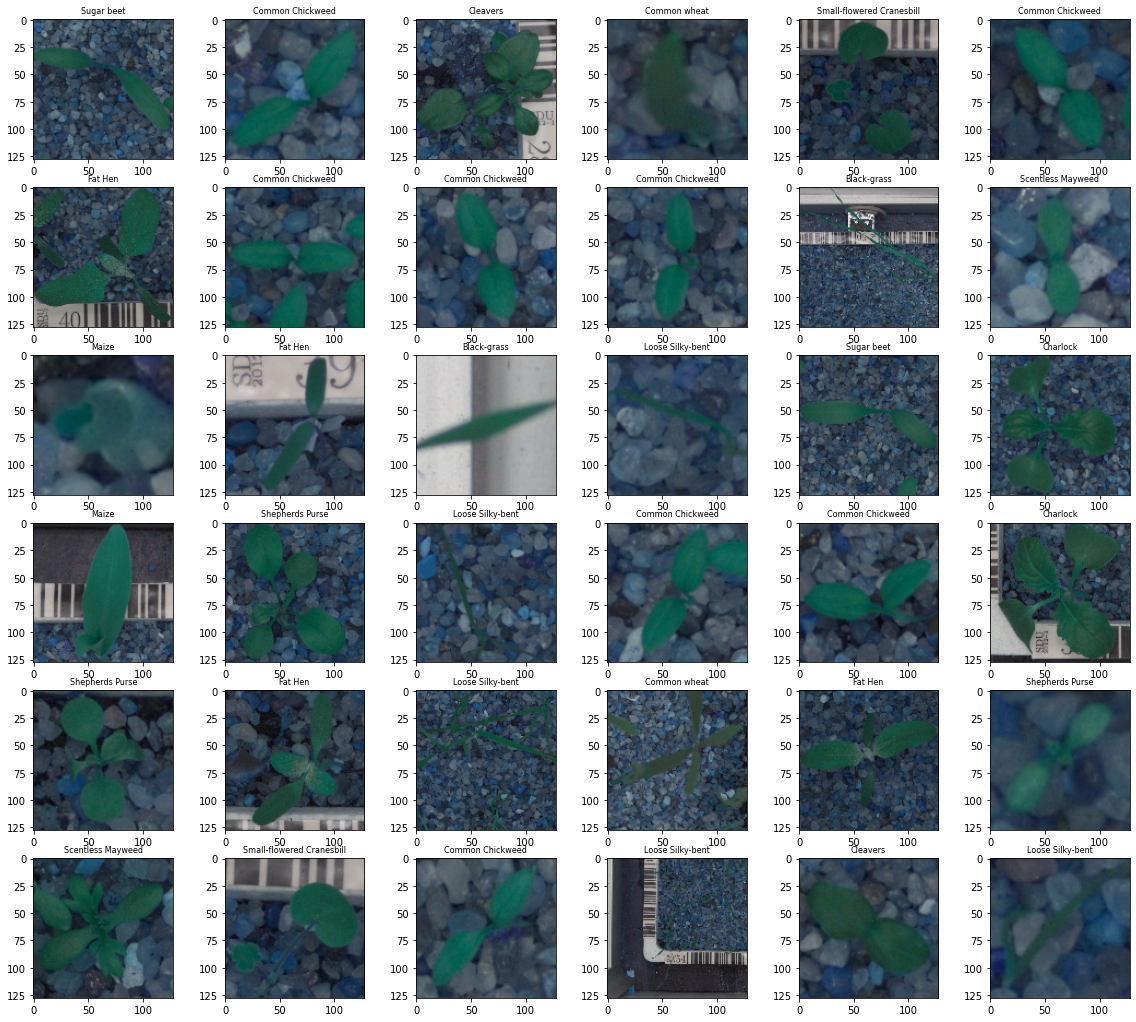

In [5]:
# Extracting a random sample of the datset to visualize the images
img_w = images.shape[1]
img_h = images.shape[2]

cols = 6
rows = 6

fig = plt.figure(figsize=(20, 18)) 
for j in range(rows):
    for i in range(cols):
        k = np.random.randint(0, len(images))
        img = images[k]
        
        ax = fig.add_subplot(rows, cols, j * cols + i + 1)
        ax.set_title(labels.iloc[k][0], fontdict={'fontsize': 8})
        ax.imshow(img)
plt.show()   

#### Observations:
* The resolution of the data can vary considerably from one image to another.
* We can observe that some species were captured at different stages of development, which can cause a negative impact on the model.
* The angles and zoom of the images are not constant.
* The background of the images is quite similar between one and the other which was beneficial for the removal of this element.

In [6]:
# Making a list of all categorical variables
cat_col = list(labels.select_dtypes("object").columns)

# Printing number of count of each unique value in each column
for column in cat_col:
    print(labels[column].value_counts())
    print("-" * 50)

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64
--------------------------------------------------


In [7]:
# function to create labeled barplots
def labeled_barplot(labels, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(labels[feature])  # length of the column
    count = labels[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=labels,
        x=feature,
        palette="Paired",
        order=labels[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show() # show the plot

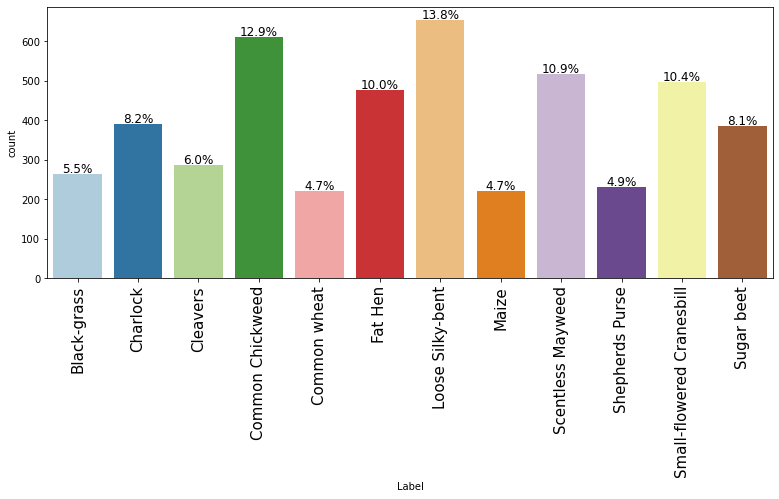

In [8]:
#Plotting the Barplot per Specie
labeled_barplot(labels, "Label", perc=True, n=12)

#### Observations:
* The first thing that we must highlight is that this project presents a data sample with an imbalance in the classes present within the dataset
* The loose silky-bent species occupies the first place within this dataset, representing 13.8% with a total of 654 samples out 4750.
* The second place corresponds to the Common Chickweed specie, representing 12.9% with a total of 611 samples out 4750.
* The third place corresponds to the Scentless Mayweed specie, representing 10.9% within the sample with a total of 516 samples out 4750.
* The fourth place corresponds to the Small-flowered Cranesbill specie, representing 10.4% within the sample with a total of 496 samples out 4750.
* The fifth place corresponds to the Fat Hen specie, representing 10% within the sample with a total of 475 samples out 4750.
* The Charlock specie occupies the sixth place within this dataset, representing a 8.2% with a total of 390 samples out 4750.
* The Sugar beet specie occupies the seventh place within this dataset, representing a 8.1% with a total of 385 samples out 4750.
* The Cleavers specie occupies the eighth place within this dataset, representing a 6% with a total of 287 samples out 4750.
* The Black-grass specie occupies the nineth place within this dataset, representing a 5.5% with a total of 263 samples out 4750.
* The Shepherds Purse specie occupies the tenth place within this dataset, representing a 5.5% with a total of 231 samples out 4750.
* The eleventh place corresponds to the Common wheat specie, representing 4.7% within the sample with a total of 221 samples out 4750.
* The twelfth place corresponds to the Maize specie, representing 4.7% within the sample with a total of 221 samples out 4750.

## DATA PREPROCESSING

In [9]:
# Checking and validating the dimension of the first image and the mean per channel 
r,g,b = images[0].T
print(g.shape)
print(r.mean())
print(g.mean())
print(b.mean())

(128, 128)
48.02557373046875
71.65386962890625
84.43310546875


In [10]:
# Balancing the weights of the classes to incorporate them later during the fitting stage
from sklearn.utils import class_weight
labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = labels['Label'].values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
class_weights

{0: 0.7980510752688172,
 1: 0.8333333333333334,
 2: 1.7135642135642135,
 3: 1.7911010558069382,
 4: 0.6478450627386798,
 5: 1.014957264957265,
 6: 1.3792102206736354,
 7: 0.7671188630490956,
 8: 1.0281385281385282,
 9: 1.7911010558069382,
 10: 1.5050697084917617,
 11: 0.605249745158002}

#### Observations:
* We observe that the classes with the major number of samples within the dataset received greater weights
* These weights will be incoporated during the model fitting stage.

# Preprocessing the images:

###  Applying filters to the dataset

### Visualizing images using Gaussian Blur 

In [11]:
#Creating a copy of the previous dataset
images1 = images.copy()

In [12]:
# Applying Gaussian Blur to denoise the images
# gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
images_gauss=[]
for i in range(len(images1)): 
    images_gauss.append(cv2.GaussianBlur(images1[i], ksize =(3,3),sigmaX =  0))

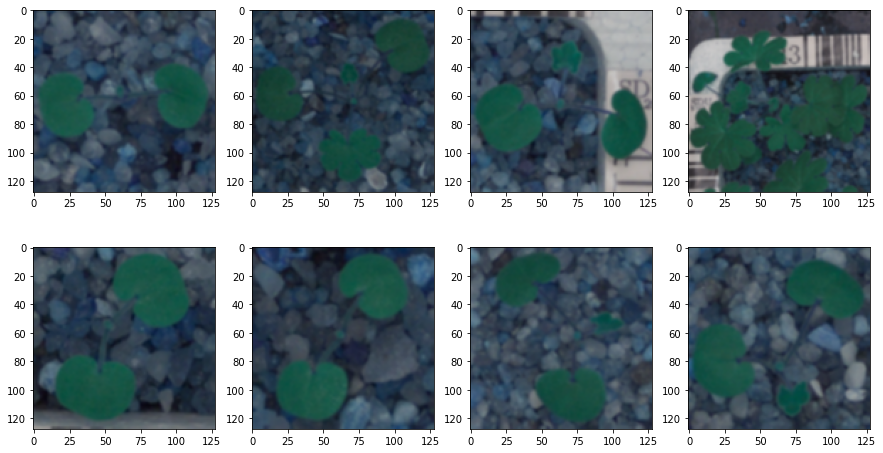

In [13]:
# Lets apply Gaussian Blur Filter 
# Plotting some of the images resulting from the Gaussian blur filter 
fig = plt.figure(figsize=(15, 8))
plt.imshow(images_gauss[2])
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images_gauss[i])

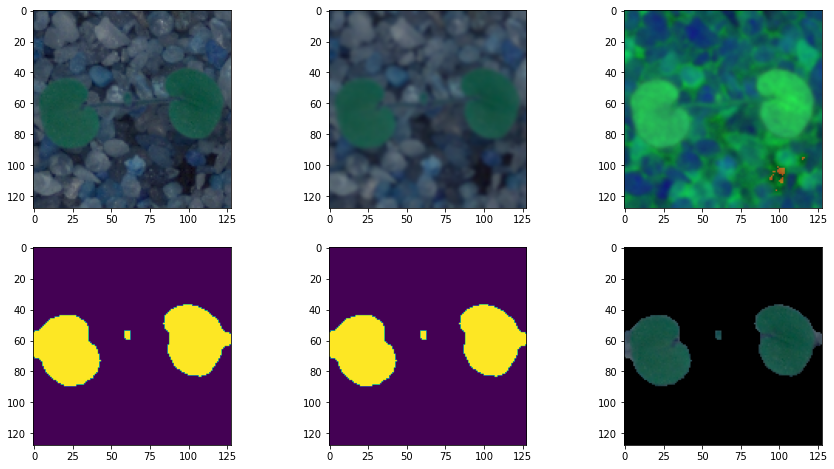

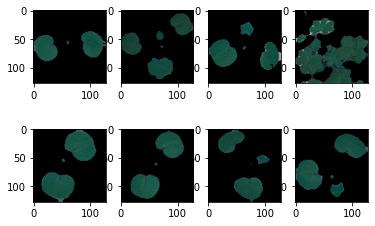

In [14]:
# Creating a new dataset applying Gaussian, HSV, and boolean filters  
# taken and adapted from kaggle computer vision competition(OMKAR SABNIS Notebook)
# suggested when you have two mask of colors 
new_set = []
sets = []; getEx = True
fig = plt.figure(figsize=(15, 8))
for i in images1:
    rows = 4
    cols = 5 
    k = 0
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
 
    # highlighting the greens and contrasts
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_set.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # Plotting the ORIGINAL IMAGE
        plt.subplot(2,3,2);plt.imshow(blurr) # Plotting the BLURRED IMAGE
        plt.subplot(2,3,3);plt.imshow(hsv) #Plotting the HSV CONVERTED IMAGE
        plt.subplot(2,3,4);plt.imshow(mask) # Plotting the MASKED IMAGE 
        plt.subplot(2,3,5);plt.imshow(boolean) # Plotting the BOOLEAN MASKED IMAGE 
        plt.subplot(2,3,6);plt.imshow(new) # FINAL PROCESSED IMAGE 
        getEx = False
    plt.show()        
new_set = np.asarray(new_set)

# Processed images
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_set[i])

In [15]:
# Validating the mean, max, and min for the new_set
print(new_set.mean())
print(new_set.max())
print(new_set.min())

12.226767479612116
255
0


#### Observations:
* We can observe how after the filtering process applied we are able to differentiate pretty much better the plants from the images.
* Applying all these filter over a prefiltered(Gaussian Blur) file maked a very evident difference to extract the silhouette of the plants.
* After these filter we can see a relationship between the area or contour occupied versus the specie of the plant.

## Normalizing the Data 

In neural networks, it is always suggested to **normalize the feature inputs**. Normalization has the below benefits while training the model of a neural network: 

1. **Normalization makes the training faster and reduces the chances of getting stuck at local optima.**
2. **weight decay and estimation can be done more conveniently** with normalized inputs.
3. In deep neural networks, **normalization helps to avoid exploding gradient problems.** Exploding Gradients problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data(extracted from Great learning notebook).

In [16]:
# Normalizing the image pixels for the new dataset with all the filters applied
new_set_normalized = new_set/255

In [17]:
# Validating the correct shape for the new normalized set
# 4750 samples, 128 x 128 pixels x 3 channels
new_set_normalized.shape

(4750, 128, 128, 3)

In [18]:
# Validating the correct shape for the labels file 
labels.shape

(4750, 1)

In [19]:
# Validating the info related to the labels files
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [20]:
# Validating the mean, max, and min for the new_set_normalized
print(new_set_normalized.mean())
print(new_set_normalized.max())
print(new_set_normalized.min())

0.047948107763185026
1.0
0.0


## Splitting the dataset

In [21]:
# Splitting the dataset as input for the modeling stage using the new_set normalized
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_set_normalized,labels , test_size=0.1, random_state=1,stratify=labels) 

In [22]:
# Validting the shape of the train and test datasets
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(4275, 128, 128, 3) (4275, 1)
(475, 128, 128, 3) (475, 1)


#### Observations:
* The x_train dataset has 4275 samples out 4750.
* The x_test dataset has 475 samples out 4750 (10%).
* The y_train(labels) dataset has 4275 samples out 4750.
* The y_test dataset(labels) has 475 samples out 4750 (10%)

## Encoding the target labels

* Converting the labels into a binary classification. The classification can be represented by an array of 12 numbers following these conditions:
  * 0 if the species is not detected.
  * 1 if the species is detected.
  * The Blackgrass specie will be represented within the the array as follow = [1,0,0,0,0,0,0,0,0,0,0,0]

In [23]:
from sklearn.preprocessing import LabelBinarizer
# Storing the LabelBinarizer function in lb variable
lb = LabelBinarizer() 
# Applying fit_transform on train target variable
y_train_e = lb.fit_transform(y_train)
# Applying only transform on test target variable
y_test_e = lb.transform(y_test)
print(y_train_e.shape, y_test_e.shape)

(4275, 12) (475, 12)


## **Model Building_1 - Convolutional Neural Network (CNN)**

In [24]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [25]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [26]:
# taken and adapted from the food_image classification project
# Intializing a sequential model
model_1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of the images
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model_1.add(Dense(100, activation='relu'))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model_1.add(Dense(12, activation='softmax'))

In [27]:
# printing the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

#### Observations:
* The number total of parameters for this model is 850.016 with no trainable parameters.

In [28]:
# Compiling the model using adam optimizer and categorical crossentropy
model_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
    
)

In [29]:
#Fitting the model on the training data
# Model history using early stopping and model checkpoint to save the weights
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('Igor_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history_1 = model_1.fit(
            x_train, y_train_e,
            epochs=30,
            batch_size=32,
            validation_split=0.1,
            callbacks=[es, mc],
            class_weight=class_weights
)

Epoch 1/30
121/121 [==============================] - 70s 573ms/step - loss: 1.8541 - accuracy: 0.4349 - val_loss: 1.2688 - val_accuracy: 0.5794

Epoch 00001: val_accuracy improved from -inf to 0.57944, saving model to Igor_model.h5
Epoch 2/30
121/121 [==============================] - 65s 539ms/step - loss: 1.0563 - accuracy: 0.6605 - val_loss: 0.9935 - val_accuracy: 0.6916

Epoch 00002: val_accuracy improved from 0.57944 to 0.69159, saving model to Igor_model.h5
Epoch 3/30
121/121 [==============================] - 68s 559ms/step - loss: 0.6795 - accuracy: 0.7777 - val_loss: 0.9681 - val_accuracy: 0.7196

Epoch 00003: val_accuracy improved from 0.69159 to 0.71963, saving model to Igor_model.h5
Epoch 4/30
121/121 [==============================] - 67s 557ms/step - loss: 0.4902 - accuracy: 0.8365 - val_loss: 0.9914 - val_accuracy: 0.6939

Epoch 00004: val_accuracy did not improve from 0.71963
Epoch 5/30
121/121 [==============================] - 67s 555ms/step - loss: 0.3738 - accuracy

### Accuracy vs Epoch Curve

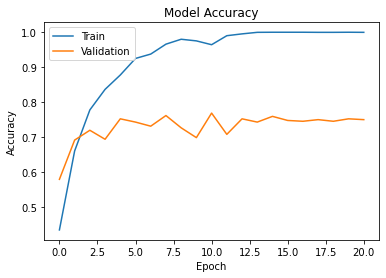

In [30]:
# Capturing the learning history per epoch
# Plotting accuracy at different epochs
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* We can observe that the behavior in the loss curve is smooth in the training curve. On the other hand, validation curve seems slightly noisy even though the optimizer utilized was the Adam optimizer.
* The slope of the training curve suggest a relative low learning rate and the model is evidently overfitting.
* The max accuracy achieved in the training dataset was 99.9% meanwhile in the test dataset the highest values was 77%.

In [31]:
# Evaluating the model in the test dataset
model_1.evaluate(x_test, y_test_e)

15/15 [==============================] - 2s 118ms/step - loss: 2.4543 - accuracy: 0.7305


[2.454285144805908, 0.730526328086853]

#### Observations:
* The Accuracy in the test dataset para el Modelo_1 is 73%.

In [33]:
# code to get the output as probablities for each category
y_pred=model_1.predict(x_test)
y_pred

array([[1.2458068e-03, 7.7408764e-09, 1.6381067e-11, ..., 4.9029693e-15,
        2.0250370e-01, 9.0277877e-07],
       [1.3043681e-06, 1.3139647e-05, 1.8570939e-10, ..., 7.1163311e-11,
        9.9992311e-01, 4.1387731e-05],
       [9.1476657e-16, 1.0976670e-16, 4.7136515e-15, ..., 7.8428485e-13,
        7.0427111e-13, 1.5703921e-10],
       ...,
       [3.2140134e-19, 1.0000000e+00, 1.6414038e-08, ..., 1.6237733e-15,
        9.3558908e-18, 4.6148457e-10],
       [4.5427322e-19, 1.2615046e-27, 1.4072539e-23, ..., 5.3774176e-09,
        8.5749541e-15, 1.3634471e-16],
       [3.5179768e-05, 4.2238335e-06, 1.5298689e-04, ..., 6.0184730e-12,
        5.5120769e-11, 9.9695265e-01]], dtype=float32)

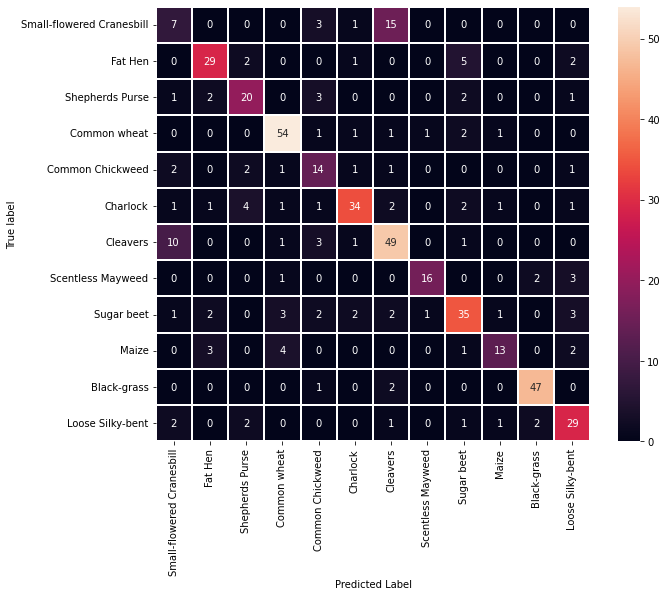

In [34]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_e,axis=1)
lab=labels['Label'].unique()

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=lab,
    yticklabels=lab,
)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.show()

In [3]:
 cr = metrics.classification_report(y_test_arg, y_pred_arg, zero_division=0,)
    print(cr)
    
    evaluate_model(model=model_1, history=history_1, X_TST=x_test, Y_TST=y_test_e)

IndentationError: unexpected indent (<ipython-input-3-90351833fd49>, line 2)

#### Observations:
* The largest numbers of correct predictions for this model1 belongs to the Common wheat and Cleavers with 54 and 49 respectively.
* The second specie with the major number of correct predictions is the Black Grass with 47, followed by the Sugar beet with 35 correct predictions.
* The specie with largest number of Incorrect predictions belong to the Small-flowered Cranesbill con 19 but it was predicted wrongly 15 times as a Cleavers since they look pretty similar in their shape and contour.

## **Model Building_2 - Convolutional Neural Network (CNN)**

In [35]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [36]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [37]:
# Intializing a sequential model
model_2 = Sequential()
# Adding the first convolutional layers according to the file input
model_2.add(Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3), padding = 'same'))
# Adding max pooling to reduce the size of output of first conv layer
# Adding batch normalization layers to normalize the contributions fro every mini batch
# Alternating maxpooling and bacth normalization layers
model_2.add(MaxPooling2D(2,2))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model_2.add(MaxPooling2D(2,2))
model_2.add(BatchNormalization())
model_2.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(32, activation='relu'))
# adding the Output layer adapting the neurons to the number of the total classes within the dataset
model_2.add(Dense(12, activation='softmax'))

In [38]:
#printing the model2 summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

#### Observations:
* The number total of parameters for this model is 300.252 with 192 trainable parameters.

In [39]:
# Compiling the model using adam optimizer and categorical crossentropy
model_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    
)

In [40]:
#Fitting the model 2 on the training data
history_2 = model_2.fit(
            x_train, y_train_e,
            epochs=30,
            batch_size=32,
            validation_split=0.1,
            class_weight=class_weights
)

Epoch 1/30
121/121 [==============================] - 83s 677ms/step - loss: 2.7430 - accuracy: 0.1682 - val_loss: 2.4739 - val_accuracy: 0.1519
Epoch 2/30
121/121 [==============================] - 72s 591ms/step - loss: 1.9784 - accuracy: 0.3886 - val_loss: 2.8778 - val_accuracy: 0.0537
Epoch 3/30
121/121 [==============================] - 71s 587ms/step - loss: 1.5976 - accuracy: 0.4744 - val_loss: 3.4471 - val_accuracy: 0.0607
Epoch 4/30
121/121 [==============================] - 78s 646ms/step - loss: 1.3616 - accuracy: 0.5487 - val_loss: 2.6896 - val_accuracy: 0.0888
Epoch 5/30
121/121 [==============================] - 77s 637ms/step - loss: 1.1906 - accuracy: 0.5906 - val_loss: 1.4468 - val_accuracy: 0.5421
Epoch 6/30
121/121 [==============================] - 78s 644ms/step - loss: 1.0222 - accuracy: 0.6551 - val_loss: 0.9080 - val_accuracy: 0.7336
Epoch 7/30
121/121 [==============================] - 73s 602ms/step - loss: 0.9281 - accuracy: 0.6787 - val_loss: 1.0249 - val_ac

### Accuracy vs Epoch Curve

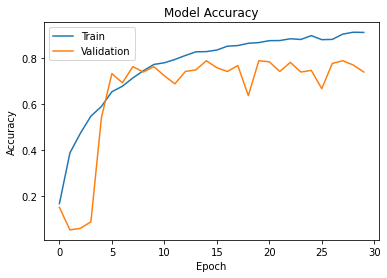

In [41]:
# Capturing the learning history per epoch
# Plotting the accuracy at different epochs
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* We can observe that the behavior in the loss curve is smooth in the training curve. On the other hand, validation curve seems slightly noisy even though the optimizer utilized was the Adam optimizer.
* The slope of the training curve suggest a relative low learning rate and the model is slightly overfitting.
* The max accuracy achieved in the training dataset was 91.3% meanwhile in the test dataset the highest values was 79%.

In [42]:
# Evaluating the model in the test dataset
model_2.evaluate(x_test, y_test_e)

15/15 [==============================] - 2s 113ms/step - loss: 1.2065 - accuracy: 0.7474


[1.206453800201416, 0.7473683953285217]

In [43]:
# code to get the output as probablities for each category
y_pred2=model_2.predict(x_test)
y_pred2

array([[1.6090067e-01, 4.9618800e-05, 8.8480601e-06, ..., 7.4893367e-05,
        2.4138439e-02, 2.3385126e-03],
       [3.0545950e-06, 9.7532368e-01, 5.8807395e-03, ..., 5.4581738e-03,
        1.1753748e-02, 8.1867492e-04],
       [1.3521061e-06, 3.7678542e-06, 1.4876594e-05, ..., 2.9183014e-03,
        2.8132702e-06, 2.2164761e-04],
       ...,
       [1.8905854e-15, 9.9748921e-01, 2.5069402e-03, ..., 2.1736865e-07,
        3.5584192e-06, 5.5206693e-09],
       [9.4180410e-12, 1.7652120e-08, 6.2827009e-12, ..., 1.8143152e-04,
        1.1995963e-04, 6.8339489e-08],
       [8.2392653e-05, 1.2166357e-05, 4.1122381e-03, ..., 4.2563363e-05,
        1.7625053e-06, 9.5419329e-01]], dtype=float32)

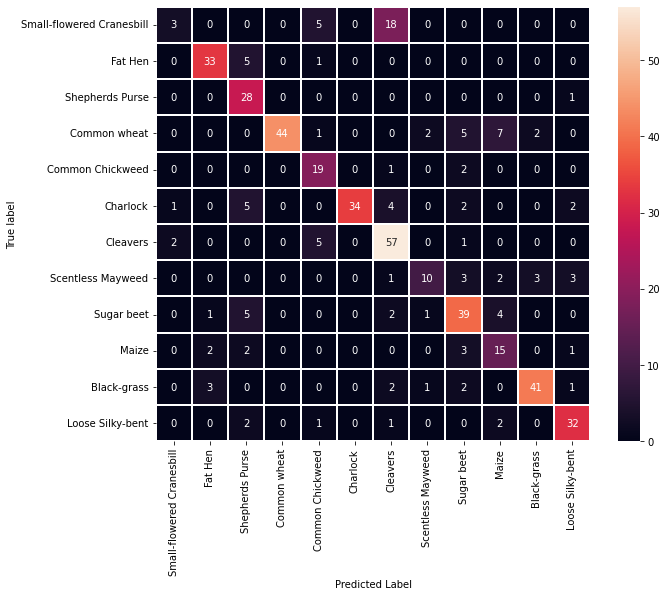

In [45]:
# Obtaining the categorical values from y_test_e and y_pred
y_pred_arg2=np.argmax(y_pred2,axis=1)
y_test_arg2=np.argmax(y_test_e,axis=1)
lab=labels['Label'].unique()

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg2,y_pred_arg2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=lab,
    yticklabels=lab,
)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.show()

In [5]:
cr = metrics.classification_report(y_test_arg, y_pred_arg, zero_division=0,)
    print(cr)
    evaluate_model(model=model_1, history=history_1, X_TST=x_test, Y_TST=y_test_e)

IndentationError: unexpected indent (<ipython-input-5-4dd3997eacff>, line 2)

#### Observations:
* The largest numbers of correct predictions for this model_2 belongs to the Cleavers and Common Wheat with 57 and 44 respectively.
* The second specie with the major number of correct predictions for the Model_2 is the Black Grass with 41, followed by the Sugar beet with 39 correct predictions.
* The specie with largest number of Incorrect predictions belong to the Small-flowered Cranesbill as in the Model_1 with 23 sample. Additionaly, it was predicted wrongly 18 times as a Cleavers since they look pretty similar in their shape and contour.

## **Model Building With Data Augmentation & Model_2 as input - Convolutional Neural Network (CNN)**

In [47]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [48]:
# Splitting the dataset for the model
X_temp, X_test, y_temp, y_test = train_test_split(new_set_normalized, labels['Label'], test_size=0.1, random_state=1, stratify=labels['Label'])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=1, stratify=y_temp)

In [49]:
# Validting the shape of the train and test datasets
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_temp.shape,y_val.shape)

(3847, 128, 128, 3) (3847,)
(475, 128, 128, 3) (475,)
(4275, 128, 128, 3) (428,)


In [50]:
# Hot enconding for the dataset after the splitting
from sklearn.preprocessing import LabelBinarizer
# Storing the LabelBinarizer function in lb variable
lb = LabelBinarizer() 
# Applying fit_transform on train target variable
y_train_e = lb.fit_transform(y_train)
# Applying only transform on test target variable
y_test_e = lb.transform(y_test)
print(y_train_e.shape, y_test_e.shape)
y_val_e = lb.transform(y_val)
print(y_train_e.shape, y_test_e.shape, y_val_e.shape)


(3847, 12) (475, 12)
(3847, 12) (475, 12) (428, 12)


In [51]:
#We can make your existing dataset even larger.
#The idea is to alter the training data with small transformations
model_gen3 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        )

model_gen3.fit(X_train)

In [52]:
#Fitting the model 3 on the training data using as the input the model_2
history_3 = model_2.fit(model_gen3.flow(X_train, y_train_e, batch_size=32),
                        validation_data=(X_val, y_val_e),
                        steps_per_epoch=X_train.shape[0] / 32,
                        epochs=30,
                        class_weight=class_weights)

Epoch 1/30
120/120 [==============================] - 85s 701ms/step - loss: 2.0709 - accuracy: 0.4255 - val_loss: 0.8096 - val_accuracy: 0.7687
Epoch 2/30
120/120 [==============================] - 75s 626ms/step - loss: 1.6688 - accuracy: 0.5022 - val_loss: 1.1849 - val_accuracy: 0.6379
Epoch 3/30
120/120 [==============================] - 80s 667ms/step - loss: 1.5308 - accuracy: 0.5360 - val_loss: 0.9620 - val_accuracy: 0.6893
Epoch 4/30
120/120 [==============================] - 77s 642ms/step - loss: 1.4386 - accuracy: 0.5591 - val_loss: 0.7369 - val_accuracy: 0.7874
Epoch 5/30
120/120 [==============================] - 76s 633ms/step - loss: 1.4233 - accuracy: 0.5641 - val_loss: 0.7274 - val_accuracy: 0.7617
Epoch 6/30
120/120 [==============================] - 74s 617ms/step - loss: 1.3042 - accuracy: 0.6059 - val_loss: 0.8284 - val_accuracy: 0.7266
Epoch 7/30
120/120 [==============================] - 76s 627ms/step - loss: 1.2678 - accuracy: 0.6140 - val_loss: 0.7166 - val_ac

In [53]:
# Evaluating the model_gen3 in the test dataset
model_2.evaluate(x_test, y_test_e)

15/15 [==============================] - 2s 100ms/step - loss: 0.6630 - accuracy: 0.7874


[0.6629706025123596, 0.7873684167861938]

#### Observations:
* The validation Accuracy for the model 3 was 78%.

### Accuracy vs Epoch Curve

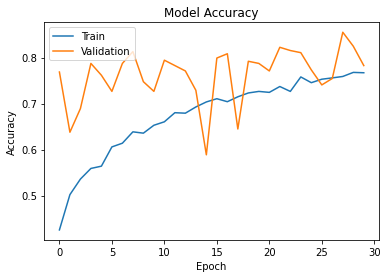

In [55]:
# Capturing learning history per epoch
# Plotting accuracy at different epochs
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations:
* We can observe that the behavior in the loss curve is smooth in the training curve. On the other hand, validation curve seems highly noisy.
* The slope of the training curve suggest a moderate learning rate and the model is overfitting.
* The max accuracy achieved in the training dataset was 76% meanwhile in the test dataset the highest accuracy reached the value of 85%.

In [56]:
# code to get the output as probablities for each category
y_pred3=model_2.predict(x_test)
y_pred3

array([[8.1556092e-04, 3.6186352e-02, 5.3561232e-03, ..., 5.6114834e-02,
        7.9235601e-01, 3.1782591e-03],
       [9.4287191e-12, 5.3796603e-04, 5.4013719e-07, ..., 1.2410655e-06,
        9.9945801e-01, 4.8677848e-08],
       [1.8195506e-05, 1.0084638e-05, 1.4167736e-04, ..., 1.6749238e-05,
        1.1641054e-04, 1.0018247e-03],
       ...,
       [3.8547805e-09, 7.1021825e-01, 2.8719175e-01, ..., 4.3036874e-07,
        2.5072636e-03, 6.8946715e-06],
       [4.9038226e-06, 3.5145527e-07, 1.8511132e-04, ..., 7.1382459e-04,
        7.7328237e-05, 1.2489254e-05],
       [1.9862221e-03, 2.3020947e-01, 3.8917133e-01, ..., 2.1048948e-02,
        5.1602520e-02, 1.8242061e-01]], dtype=float32)

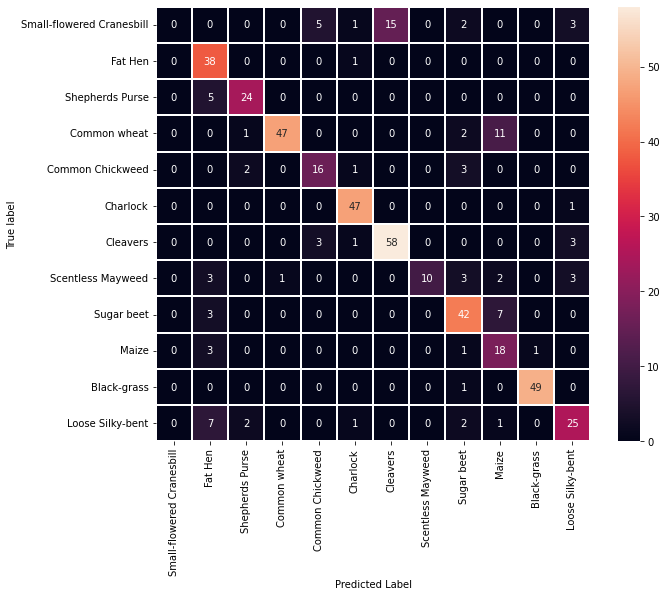

In [58]:
# Obtaining the categorical values from y_test_e and y_pred
y_pred_arg3=np.argmax(y_pred3,axis=1)
y_test_arg3=np.argmax(y_test_e,axis=1)
lab=labels['Label'].unique()

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg3,y_pred_arg3)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax,
    xticklabels=lab,
    yticklabels=lab,
)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.show()

#### Observations:
* The largest numbers of correct predictions for this model_3(called 2 wrongly) belongs to the Cleavers and Black Grass with 58 and 44 respectively.
* The second species with the major number of correct predictions for the Model_3(called 2 wrongly) are the Common Wheat and the Charlock species, both with 47.
* The specie with largest number of Incorrect predictions belong to the Small-flowered Cranesbill with 24 samples, as we saw in the models 1 and 2. Additionaly, it was predicted wrongly 15 times as a Cleavers and 5 times Common Chickweed.
* The Black grass had just one wrong prediction as a Sugar beet specie.

### **Visualizing predicted images**

Lets check some predictions using the best 0f the 3 models,  which was the model_3(with model2 label) by plotting one random image from x_test data with variable and see if our best model is predicting the image correctly or not.

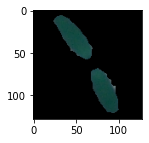

Predicted Label ['Fat Hen']
True Label Fat Hen


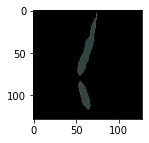

Predicted Label ['Common wheat']
True Label Black-grass


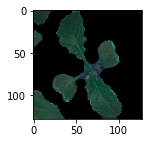

Predicted Label ['Charlock']
True Label Charlock


In [69]:
# Visualizing the predicted versus the correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(x_test[2])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict(x_test[2].reshape(1,128,128,3))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_e)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(x_test[33])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict((x_test[33].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_e)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(x_test[36])
plt.show()
print('Predicted Label', lb.inverse_transform(model_2.predict((x_test[36].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', lb.inverse_transform(y_test_e)[36])                                             # using inverse_transform() to get the output label from the output vector

#### Observations:
* We can observe that for a sample of 3 species the model interpreted the image properly.

## Actionable Insights, Conclusions and Recommendations

* There is an evident imbalance of the classes within the classes.
* The image file correspond to a numpy array (.npy), which allows make the operations computationally faster.
* The file with the images contains 4750 images with a dimension of 128 x 128 x 3 channels RGB.
* The labels files contains 4750 labels corresponding to the label of each image.
* The loose silky-bent species occupies the first place within this dataset, representing 13.8% with a total of 654 samples out 4750.
* The second place corresponds to the Common Chickweed specie, representing 12.9% with a total of 611 samples out 4750.
* The third place corresponds to the Scentless Mayweed specie, representing 10.9% within the sample with a total of 516 samples out 4750.
* The fourth place corresponds to the Small-flowered Cranesbill specie, representing 10.4% within the sample with a total of 496 samples out 4750.
* The fifth place corresponds to the Fat Hen specie, representing 10% within the sample with a total of 475 samples out 4750.
* The Charlock specie occupies the sixth place within this dataset, representing a 8.2% with a total of 390 samples out 4750.
* The Sugar beet specie occupies the seventh place within this dataset, representing a 8.1% with a total of 385 samples out 4750.
* The Cleavers specie occupies the eighth place within this dataset, representing a 6% with a total of 287 samples out 4750.
* The Black-grass specie occupies the nineth place within this dataset, representing a 5.5% with a total of 263 samples out 4750.
* The Shepherds Purse specie occupies the tenth place within this dataset, representing a 5.5% with a total of 231 samples out 4750.
* The eleventh place corresponds to the Common wheat specie, representing 4.7% within the sample with a total of 221 samples out 4750.
* The twelfth place corresponds to the Maize specie, representing 4.7% within the sample with a total of 221 samples out 4750.
* The resolution of the data can vary considerably from one image to another.
* We can observe that some species were captured at different stages of development, which can cause a negative impact on the model.
* The angles and zoom of the images is not constant.
* The background of the images is quite similar between one and the other which was beneficial for the removal of the background.
* The first thing that we must highlight is that this project presents a data sample with an imbalance in the classes present within the dataset
* * The largest numbers of correct predictions for this model1 belongs to the Common wheat and Cleavers with 54 and 49 respectively.
* The second specie with the major number of correct predictionswithin the Model_1 is the Black Grass with 47, followed by the Sugar beet with 35 correct predictions.
* The specie with largest number of Incorrect predictions within the Model_1 belongs to the Small-flowered Cranesbill con 19 but it was predicted wrongly 15 times as a Cleavers since they look very similar.
* The largest numbers of correct predictions for the model_2 belongs to the Cleavers and Common Wheat with 57 and 44 respectively.
* The second specie with the major number of correct predictions for the Model_2 is the Black Grass with 41, followed by the Sugar beet with 39 correct predictions.
* The specie with largest number of Incorrect predictions belongs to the Small-flowered Cranesbill with 23 sample as the Model_1. Additionaly, it was predicted wrongly 18 times as a Cleavers since they look pretty similar in their shape and contour.
* The largest numbers of correct predictions for the model_3(called 2 wrongly) belongs to the Cleavers and Black Grass with 58 and 44 correct predictions respectively.
* The second species with the major number of correct predictions for the Model_3(called 2 wrongly) are the Common Wheat and the Charlock species, both with 47.
* The specie with largest number of Incorrect predictions belongs to the Small-flowered Cranesbill with 24 samples, as we saw in the models 1 and 2. Additionaly, it was predicted wrongly 15 times as a Cleavers and 5 times Common Chickweed.
* The Black grass had just one wrong prediction as a Sugar beet specie.
* La iteracion de modelo 3 (Model_2), corresponding to the incorporation of the Data Augmentation elements with the Model_2 as input, obtained a Validation Accuracy of 78%. However, the validation curve was evidently noisy. On te other hand, we took a sample of three images from different species and the model interpreted them correctly.
* The most complicate specie to interpret for the models was the Small-Flowered cranesbill which was usually predicted wrongly as Claeaver.
* The easier species to interpret for the models the Cleavers, Common Wheat, Charlock, Sugar Beet, among others, since they were predicted correctly the most of the time along the 3 models ran.
* It is recommended to make an analysis of contours and occupied areas in the photo by species and run a statistical analysis with respect to these factors.
* It is recommended to do a spectral analysis of colors by species in order to know the real ranges by species and apply the filters according to these values.
* In order to complete the project and within the capabilities of the personal equipments, we proceeded with the design of models with manageable parameters. However, it is recommended to design more robust architectures that involve the use of other parameters in order to improve the outputs of the models, like the VGG16.